In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts


### Simulating haplotypes from custom frequency distributions. 

In this notebook we test the capacity of kernel density estimation to correctly classify haplotypes as a function of the genetic distance between reference samples. The classification and structure manipulation protocol is the same as used in other notebooks (links below).

The important difference in this case is the allele frequency distribution used to simulate allele frequency vectors. While before we had relied on the Beta distribution, now we will sample allele frequencies from a distribution extracted from real data.

The script `cluster_frequencies.py` was used to calculate allele frequencies at local mean shift clusters across the rice genome. These frequencies were stored in a data set in this repository. Our first step is to read them and estimate the observed distribution.

The generation of haplotype data sets relies on a data set of allele frequency distributions. Regarding this data set, this notebook allows to options:

- Original: use the true allele frequencies estimated from real data. This option is selected by setting `origin` to True bellow.

- inferred: generate new allele frequency vectors by sampling from the observed distribution of allele frequencies.

this notebook allows two strategies to manipulate the genetic distance between samples:

- PCA: perform PCA on the data set of allele frequencies selected. Rely on a positive relation between the euclidean distance between vectors in feature space and Fst to generate new vectors through inverse transformation. All components are kept to ensure reliable transformation.

- Vector selection: begin by calculating Fst between all pairs of vectors in the frequency vector data set. Then, at each step of the simulation, select pairs of vectors presenting an Fst value close to that required for the test. This option is chosen by setting `range_select` to True bellow.

In [2]:
range_select= True

origin= True

In [3]:
Home= 'CLfreq_one' + '/'

### Freqs

filename= Home + 'CLfreq_one_freqs.txt'

freqs_dict= recursively_default_dict()
freqs_matrix= []

Input= open(filename,'r')

for line in Input:
    line= line.split()
    
    freqs_matrix.append([float(line[x]) for x in range(3,len(line))])
    freqs_dict[int(line[0])][float(line[1])][float(line[2])]= [float(line[x]) for x in range(3,len(line))]
Input.close()



In [4]:
### An initial filtering:
freq_threshold= 0.1

where_NA= [x for x in freqs_matrix if max(x) >= freq_threshold]

print('{} max freq below threshold'.format(len(freqs_matrix) - len(where_NA)))

freqs_matrix= np.array(freqs_matrix)

73 max freq below threshold


In [5]:

n_chose= 200
Chose= np.random.choice(range(freqs_matrix.shape[0]),n_chose)

Across= list(it.chain(*[freqs_matrix[x] for x in Chose]))

X_plot = np.linspace(0, 1, 1000)

freq_kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(Across).reshape(-1,1))

log_dens = freq_kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'mRNA pVal',
                            line=dict(color='blue', width=2))]
##

layout= go.Layout(
    title= 'allele frequency distribution across clusters',
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'frequency'
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)


In [6]:
from structure_tools.Generate_freq_vectors import generate_vectors_kde

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 150
n= 300

n_comp = L
density= 50


if origin:
    vector_lib= np.array(freqs_matrix)
else:
    vector_lib= generate_vectors_kde(freq_kde,L,n)


We will now reduce the dimensions of this data. However, in this case we don't expect to find structure. We created our vectors randomly within our ranges. This feature space will be used solely to retrieve new vectors through inverse transformation following operations that are not limited to 3 dimensions. Thus, we will try to keep as much of the information as possible for that transformation.

In [7]:
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(881, 150)
(881, 150)


In [8]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter(
        x = features[:,0],
        y = features[:,1],
        mode= "markers",
        text= [str(x) for x in range(features.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


By hovering above the points, we see that variation along the first axis is usually correlated with the _a_ and _b_ parameters of the beta distribution.

**[Note]** If you played around with these parameters you will have noticed the beta distribution becomes less skewed as they rise. Although this relation is not linear, it will generally translate into vectors with a larger number of higher frequencies.

Other considerations aside, we will chose a number of populations from among these - i have set this number to 3. To change it, add or remove from the list 'Pops' and modify the list 'Sizes' as well.

The next block of code will calculate global and pairwise Fsts among the populations chosen. Modify your choice until you are happy with these values, i don't really have a better way to inform this choice right now.


In [9]:
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [10]:
### distribution of genetic distances generated on first layer:
from structure_tools.StructE_tools import return_fsts, return_fsts2

N_sample= 200

Pops_test= np.random.choice(vector_lib.shape[0],N_sample,replace= False)

Fsts_test= return_fsts2(vector_lib[Pops_test,:])


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Cluster_shape\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
### Distribution of feature space distances between control populations for even and biased scenarios
from sklearn.neighbors import KernelDensity
Fsts_den= Fsts_test.fst

Fsts_den= np.nan_to_num(Fsts_den)

X_plot = np.linspace(0, .5, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(np.array(Fsts_den).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Biased senarios',
                            line=dict(color='blue', width=2))]

##

layout= go.Layout(
    title= 'Distribution of genetic distances generated in layer I.',
    xaxis= dict(
        range= [0,.5]
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)

In [12]:

def fst_select(fst_test,fst,range_allow= 0.01):
    
    diff_dict= {
        x: abs(fst - fst_test.fst[x]) for x in range(fst_test.shape[0])
    }
    
    present= [x for x in diff_dict.keys() if diff_dict[x] <= range_allow]
    
    if present:
        provide= np.random.choice(present,1)[0]
        return fst_test.pops[provide]
    
    else:
        suspicious= sorted(diff_dict,key= diff_dict.get)
        
        return fst_test.pops[suspicious[0]]

    

Finally, for capturing regions of overlap between our populations.

We will pick two populations from among our choices and we will make their distance vary in the feature space of frequency vectors. We will do this by once again resorting to the sinusoid of their distance.

At each variation, we will calculate the pairwise fsts among all our populations. we will also store the distances separating our vectors in feature space. We will plot these values against each other afterwards.

We will first need to slightly modify our **return_fsts** function. Fsts of loci with 0 variation will be set to 0. This will still produce a runtime warning as it first attemps to divide by 0. Stay calm.

In [13]:
#### We're going to do something different now. We'll have two points get closer together in time.
min_fst= np.min(Fsts_test.fst)
max_fst= np.max(Fsts_test.fst)

#range_fst= max_fst - min_fst
#fst_middle= (max_fst + min_fst) / float(2)

range_fst= 0.15
fst_middle= 0.075

#first chose two
target= [0,1]
#### calculating Fsts between populations.
Pops= [131,420]

reference_fst= return_fsts2(vector_lib[Pops,:])
print(reference_fst.fst)

fst_labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(-10,10,.05):
    
    progress= angle / 10
    
    #fst_wanted= min_fst + progress * range_fst
    fst_wanted= sin(angle*2) * (range_fst / 2) + fst_middle
    
    if range_select:
        
        who= fst_select(Fsts_test,fst_wanted,range_allow= 0.01)
        who= [Pops_test[x] for x in who]
        
        coords= features[who,:]
        new_freqs= vector_lib[who,:]
    
    else:
        coords= features[Pops,:]
        vector2= coords[target[0]] - coords[target[1]]

        #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
        coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]

        new_freqs= pca.inverse_transform(coords)

        #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
        new_freqs[new_freqs > 1] = 1
        new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    fst_labels.extend([tuple([x + 1 for x in y]) for y in Pairwise.pops])
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Cluster_shape\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



0    0.284707
Name: fst, dtype: float64


In [45]:
fig_data= [go.Scatter(
x= Distances_crawl,
y= Fsts_crawl,
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

We can see that distances in feature space aren't linearly correlated to among-population fsts. This is to be expected. However the relationship is globally positive, i'll take that as a win and procede.

In [46]:
coords= {z:[x for x in range(len(fst_labels)) if fst_labels[x] == z] for z in list(set(fst_labels))}


fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'markers',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]


layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)


fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)


Globally, we learn that distances in vector feature space are indeed related to the amount of differentiation among our populations. 

Now we will will perform the same exercice, but at each step we will draw haplotypes from our vectors. We will then reduce the dimensionality of our haplotype data set, and estimate the kernel density of each population in that space.

The values of each KDE at the coordinates of our drawn observations (haplotypes) will be extracted.

In [47]:
from structure_tools.StructE_tools import extract_profiles
from IPython.display import clear_output
from structure_tools.Modules_tools import extract_profiles_union


Sizes= [200,200]
labels= [0,1]
target= [0,1]

label_vector= np.repeat(np.array([x for x in labels]),Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}

Windows= recursively_default_dict()
Union_profile= []
Blocks_truth= recursively_default_dict()

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in target}
threshold= .005
P= 50
n_comps= 5

Fst_labels= []

Fst_crawl= []

Fst_windows= []

var_comp_store= []

for angle in np.arange(-10,10,.1):
    print(angle)
    print(Union_profile)
    progress= angle / 10
    
    #fst_wanted= min_fst + progress * range_fst
    fst_wanted= sin(angle*2) * (range_fst / 2) + fst_middle
    
    if range_select:
        
        who= fst_select(Fsts_test,fst_wanted,range_allow= 0.01)
        who= [Pops_test[x] for x in who]
        
        coords= features[who,:]
        new_freqs= vector_lib[who,:]
    
    else:
        coords= features[Pops,:]
        vector2= coords[target[0]] - coords[target[1]]

        #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
        coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]

        new_freqs= pca.inverse_transform(coords)

        #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
        new_freqs[new_freqs > 1] = 1
        new_freqs[new_freqs < 0] = 0
    
    
    N_pops= len(Pops)
    
    local_labels= np.repeat(np.array([x + 1 for x in range(N_pops)]),Sizes)
    
    data= []

    for k in range(N_pops):

        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        m= Sizes[k]
        Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]

        data.extend(Haps)
    
    data= np.array(data)
    pca2 = PCA(n_components=n_comps, whiten=False,svd_solver='randomized').fit(data)

    data= pca2.transform(data)
    
    local_pcvar= list(pca2.explained_variance_ratio_)

    local_pcvar= [angle,*local_pcvar]

    var_comp_store.append(local_pcvar)
    
    profiles= extract_profiles(data,target_indx)
    
    #if len(labels) == 2:
        #overlap= extract_profiles_union(data,label_indicies,threshold= threshold,P= P)
        #print(overlap[tuple(labels)]['PU'])
    
    ##### FSTs
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([angle] * Pairwise.shape[0])

    ### store stuff.
    
    Blocks_truth[int(angle*1000)]= local_labels
    Windows[int(angle*1000)]= profiles
    #if len(labels) == 2:
        #Union_profile.append(overlap[tuple(labels)]['PU'])
    clear_output()


var_comp_store= np.array(var_comp_store)
var_comp_store= pd.DataFrame(var_comp_store,columns=['set',*['PC' + str(x + 1) for x in range(n_comps)]])

Blocks_truth= {1:Blocks_truth}
Windows= {1:Windows}

To wrap up we will classify each observation according to the KDE values it received at every step.

We will allow for pure, intermediate and outlier classes.

We will plot these classifications in the form of an ideogram and resort to the same color sceme as in the previous post. 


**pure classes**:
- pop1: red
- pop2: yellow
- pop3: blue

**Intermediate classes**
- pop1-pop2: orange
- pop2-pop3: green
- pop1-pop3: purple
- po1-pop2-pop3: silver

Assignments at varying steps of X will be plotted as a global ideogram.

-  Comparison_threshold= 5
-  Outlier_threshold= 1e-4


Functions `Merge_class()` (classification of collection of analyses), `compress_Ideo()` (reduce classification data set) and `return_Ideogram()` (plot classification across collection, uses matplotlib) can be found in Ideogram_tools.py


In [48]:
## set classification parameters, colors and organise input.
from structure_tools.Ideogram_tools import Merge_class

Out= {y:{x:x + 99 for x in Windows[y].keys()} for y in Windows.keys()}
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 1
Outlier_threshold= 1e-4
color_ref= ['red','yellow','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

In [49]:
# prepare final classification data set

chromosome_list = []

Ideo = []

chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)


In [50]:
#### begin by compressing assignments by individuals. Lightens the load of the following plot.
from structure_tools.Ideogram_tools import compress_ideo

import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)


adding ideograms...


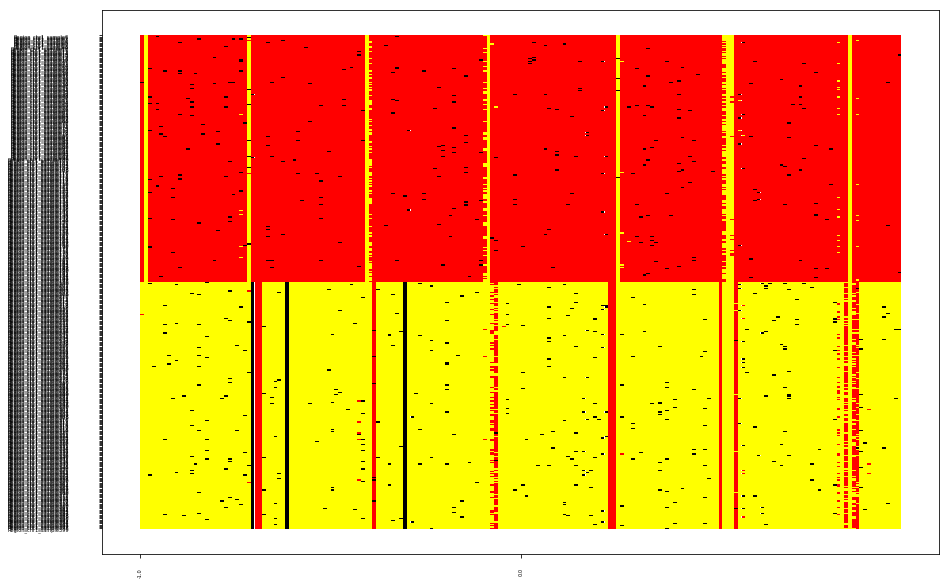

In [51]:
from structure_tools.Ideogram_tools import return_ideogram

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID,height= 10,width= 15)

In [52]:
wind= []
Proportions= []
labs= []
for w in Windows[1].keys():
    for combo in it.combinations(Windows[1][w].keys(),2):
        diffs= [abs(Windows[1][w][combo[0]][x] - Windows[1][w][combo[1]][x]) for x in range(len(Windows[1][w][combo[1]]))]
        
        Proportions.append(np.mean(diffs))
        labs.append(tuple([x+1 for x in combo]))
        wind.append(w)



In [53]:
coords= {z:[x for x in range(len(labs)) if labs[x] == z] for z in list(set(labs))}
Accuracy= []
where= []
Outlier_rate= []

Like_ratio= []
Misshaps= []

labels= [1,2]

for bl in Blocks[1].keys():
    outliers= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] == len(labels) + 1]
    non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != len(labels) + 1]
    misshaps= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != Blocks_truth[1][bl][x] and Blocks[1][bl][x] in labels]
    
    light_ration= {
        x: [Windows[1][bl][z-1][0][x] for z in labels] for x in non_outlier
    }
    
    if len(labels) == 2:
        light_ration= {
            x:(min(light_ration[x])) / max(light_ration[x]) for x in light_ration.keys()
        }
        
        Like_ratio.extend([light_ration[x] for x in sorted(light_ration.keys())])
        Misshaps.extend([int(x in misshaps) for x in sorted(light_ration.keys())])
    
    gp_non_out= {
        z: float(len([x for x in non_outlier if Blocks_truth[1][bl][x]==z])) for z in labels
    }
    
    gp_out= {
        z: float(len([x for x in outliers if Blocks_truth[1][bl][x]==z])) for z in labels
    }
    
    gp_non_out= {
        z: gp_non_out[z] for z in gp_non_out.keys() if gp_non_out[z]
    }
    
    gp_out= {
        z: gp_out[z] for z in gp_out.keys() if gp_out[z]
    }
    
    if not gp_out:
        out_rate= 0
    else:
        out_rate= np.mean([gp_out[z] / len(Blocks_truth[1][bl][Blocks_truth[1][bl] == z]) for z in gp_out.keys()])
    
    rate= np.mean([1 - len([x for x in misshaps if Blocks_truth[1][bl][x]==z]) / gp_non_out[z] for z in gp_non_out.keys()])
    
    Outlier_rate.append(out_rate)
    Accuracy.append(rate)
    where.append(bl)


fig_data= [go.Scatter(
y= Accuracy,
x= Fst_crawl,
mode= 'markers'
)
]

layout = go.Layout(
    title= 'Accuracy by Fst between references',
    yaxis=dict(
        title='Accuracy',
        range= [0,1.1]),
    xaxis=dict(
        title='Fst',
        range= [0,.15])
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

### Variance captured

In [54]:
var_comp_store.head()

,set,PC1,PC2,PC3,PC4,PC5
0,-10.0,0.650481,0.152164,0.057804,0.039711,0.028523
1,-9.9,0.187215,0.070829,0.061853,0.054160,0.050866
2,-9.8,0.827666,0.117537,0.019089,0.009682,0.006457
3,-9.7,0.824405,0.028507,0.023834,0.021920,0.015503
4,-9.6,0.580233,0.054226,0.049288,0.047861,0.041645


In [55]:
n_comp= var_comp_store.shape[1] - 1
PC_list= ['PC' + str(x + 1) for x in range(n_comp)]
total_var= var_comp_store[PC_list].sum(axis= 1)


X_plot = np.linspace(-0.1, 1.1, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(total_var).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'variance captured',
                            line=dict(color='blue', width=2))]
##


layout= go.Layout(
    title= 'ncomp: {}'.format(n_comp),
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'variance explained'
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)

In [56]:
how_much= .8

how_many= sum(total_var >= how_much) / float(len(total_var))
print('% data sets with above {} var explained: {}'.format(how_much*100,how_many))

% data sets with above 80.0 var explained: 0.805


In [57]:

trace1 = [go.Box(
    y=total_var
)]

layout= go.Layout(
    title= 'ncomp: {}'.format(n_comp),
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'variance explained'
    )
)

fig= go.Figure(data= trace1,layout= layout)
iplot(fig)

In [44]:

fig_data= [go.Scatter(
y= [Accuracy[x] for x in coords[i]],
x= [total_var[x] for x in coords[i]],
mode= 'markers',
name= ' pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'average KDE score differences',
    yaxis=dict(
        title='Accuracy'),
    xaxis=dict(
        title='total var')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)


In [32]:
### Use *p*-value threshold to mask error

adding ideograms...


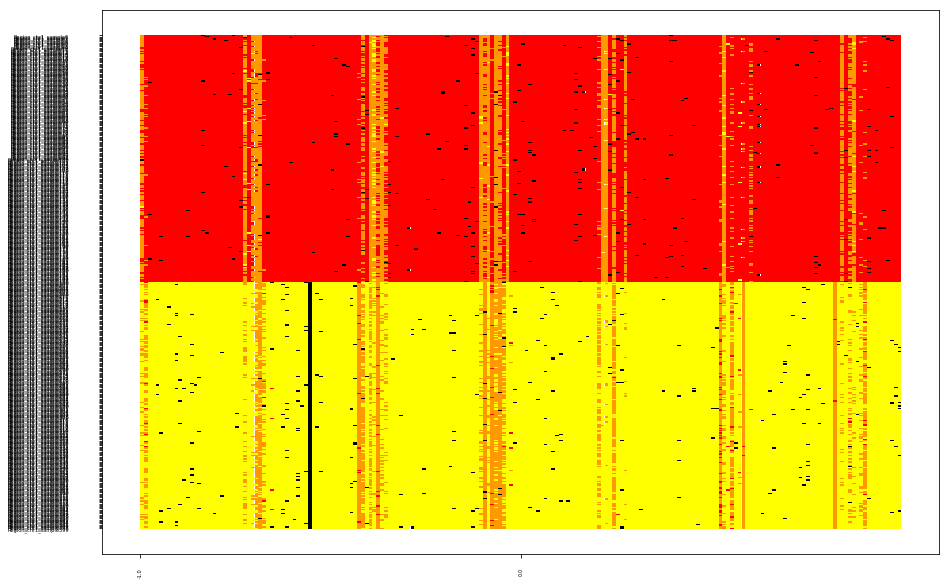

In [33]:
Comparison_threshold= 4
Outlier_threshold= 1e-4
color_ref= ['red','yellow','black','orange','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

chromosome_list = []

Ideo = []

chromosomes= Blocks2.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)
ID= 'th' + str(Comparison_threshold)

fig= return_ideogram(ideo, chromosome_list,ID,height= 10,width= 15)


In [78]:
coords= {z:[x for x in range(len(labs)) if labs[x] == z] for z in list(set(labs))}
Buffer= []

Intermediate= []

labels= [1,2]

for bl in Blocks[1].keys():
    non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != len(labels) + 1]
    inter= [x for x in range(len(Blocks2[1][bl])) if Blocks2[1][bl][x] > (len(labels) + 1)]
    
    Intermediate.extend([int(x in inter) for x in non_outlier])
    
    gp_non_out= {
        z: float(len([x for x in non_outlier if Blocks_truth[1][bl][x]==z])) for z in labels
    }
    
    gp_non_out= {
        z: gp_non_out[z] for z in gp_non_out.keys() if gp_non_out[z]
    }
    
    rate= np.mean([len([x for x in inter if Blocks_truth[1][bl][x]==z]) / gp_non_out[z] for z in gp_non_out.keys()])
    
    Buffer.append(rate)
    where.append(bl)


fig_data= [go.Scatter(
y= Buffer,
x= 1 - np.array(Accuracy),
mode= 'markers'
)
]

layout = go.Layout(
    title= 'Intermediate assignment and Accuracy',
    yaxis=dict(
        title='Intermediate assignment',
        range= [0,1]),
    xaxis=dict(
        title='Error rate',
        range= [0,1])
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [87]:
from sklearn.neighbors import KernelDensity

accurate= [Like_ratio[x] for x in range(len(Like_ratio)) if Misshaps[x] == 0]
errors= [Like_ratio[x] for x in range(len(Like_ratio)) if Misshaps[x] == 1]

Cured= [Like_ratio[x] for x in range(len(Like_ratio)) if Intermediate[x] == 1]

##

X_plot = np.linspace(-.1, 1.1, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(accurate).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Prop_correct',
                            line=dict(color='blue', width=2))]
##


X_plot = np.linspace(-.1, 1.1, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(errors).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens.append(go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Prop_miss',
                            line=dict(color='red', width=2)))
##


X_plot = np.linspace(-.1, 1.1, 100)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(Cured).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens.append(go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Prop_inter',
                            line=dict(color='orange', width=2)))

##

layout= go.Layout(
    title= 'Ref likelihood proportion by classification accuracy',
    xaxis= dict(
        title= 'minimum p-val proporiton',
        range= [-.1,1.1]
    ),
    yaxis= dict(
        title= 'density'
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)